<a href="https://colab.research.google.com/github/RutwikP/Transfer-Learning-for-Oral-Cancer-Detection-using-Microscopic-Images/blob/main/OralCancer_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import sklearn
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)


print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.4.1
Hub version: 0.11.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [ ]:

# For inception_v3 and mobilenet_v2
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))


'''
# For resnet_50
module_selection = ("resnet_50", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
'''

'''
# For vggnet
module_selection = ("vggnet", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
'''

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4 with input size (299, 299)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.1,
   **datagen_kwargs)

# TODO: replace directory link with new validation directory
valid_generator = valid_datagen.flow_from_directory(
    '/content/drive/My Drive/og3_valid_set',
    shuffle = False,
    **dataflow_kwargs
)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2, validation_split=0.1,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen

# TODO: replace directory link with new train directory
train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/og3_train_set', shuffle=True, **dataflow_kwargs)

Found 124 images belonging to 2 classes.
Found 968 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'Cancerous': 0, 'Normal': 1}

In [ ]:
#weight_for_cancer = (1 / 748)*(968)/2.0
#weight_for_normal = (1 / 222)*(968)/2.0

#class_weight = {0: weight_for_cancer, 1: weight_for_normal}

#print('Weight for class 0: {:.2f}'.format(weight_for_cancer))
#print('Weight for class 1: {:.2f}'.format(weight_for_normal))

In [ ]:
do_fine_tuning = True #@param {type:"boolean"}

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=10, steps_per_epoch=steps_per_epoch,#class_weight = class_weight,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/10
30/30 [==============================] - 866s 28s/step - loss: 0.8021 - accuracy: 0.7484 - val_loss: 0.6245 - val_accuracy: 0.8958
Epoch 2/10
30/30 [==============================] - 122s 4s/step - loss: 0.6302 - accuracy: 0.8809 - val_loss: 0.8583 - val_accuracy: 0.6042
Epoch 3/10
30/30 [==============================] - 120s 4s/step - loss: 0.5891 - accuracy: 0.9067 - val_loss: 1.6602 - val_accuracy: 0.4271
Epoch 4/10
30/30 [==============================] - 120s 4s/step - loss: 0.6003 - accuracy: 0.9025 - val_loss: 0.6159 - val_accuracy: 0.8646
Epoch 5/10
30/30 [==============================] - 120s 4s/step - loss: 0.5716 - accuracy: 0.9247 - val_loss: 0.5722 - val_accuracy: 0.8958
Epoch 6/10
30/30 [==============================] - 120s 4s/step - loss: 0.5259 - accuracy: 0.9536 - val_loss: 0.8132 - val_accuracy: 0.7812
Epoch 7/10
30/30 [==============================] - 120s 4s/step - loss: 0.5110 - accuracy: 0.9596 - val_loss: 0.8722 - val_accuracy: 0.7812
Epoch 8/10
3

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   **datagen_kwargs)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/og3_3_test_mom_images_2',
    shuffle = False,
    **dataflow_kwargs
)

#predictions = model.predict_classes(test_generator)
#print(predictions)
#probs = tf.nn.softmax(predictions)
#print(probs)
preds = model.evaluate(test_generator)
preds = model.predict_classes(test_generator)

Found 138 images belonging to 2 classes.
5/5 [==============================] - 94s 23s/step - loss: 0.6965 - accuracy: 0.8406


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
test_generator.class_indices

{'Cancerous': 0, 'Normal': 1}

In [ ]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1])

In [ ]:
 labels = test_generator.labels

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, _ = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
def plot_roc(name, labels, preds):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, preds)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

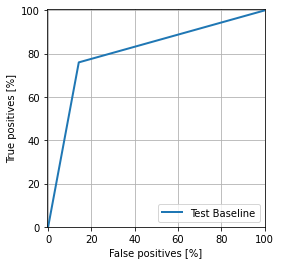

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
#plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", labels, preds)
plt.legend(loc='lower right')

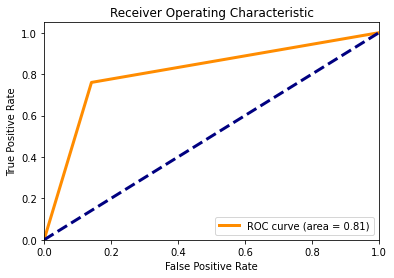

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

[[97 16]
 [ 6 19]]


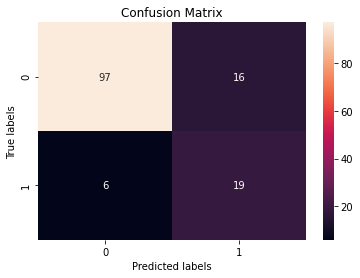

In [ ]:

# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
expected = labels
predicted = preds
results = confusion_matrix(expected, predicted)
print(results)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(results, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

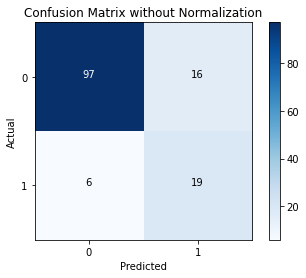

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix 

plt.imshow(results,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(labels))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = results.max() / 2.
for i,j in itertools.product(range(results.shape[0]),range(results.shape[1])):
    plt.text(j,i,format(results[i,j],'d'),horizontalalignment='center',color='white' if results[i,j] >thresh else 'black')
plt.show();

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
y_true = labels
y_pred = preds
precision_recall_fscore_support(labels, preds, average='macro')

(0.7423023578363384, 0.8092035398230089, 0.7657407407407406, None)